# １章 ウェブの注文数を分析する

ここでは、ある企業のECサイトでの商品の注文数の推移を分析していきます。  
データの属性を理解し、分析をするためにデータを加工した後、  
データの可視化を行うことで問題を発見していくプロセスを学びます。

### ノック１：データを読み込んでみよう

⬜︎pandasはデータ解析ライブラリ
CSVやEXCELなどにデータの入出力ができる
多種の型のデータを一つのデータフレームで扱える
データ加工や解析の関数が多い
表形式のデータをSQLやRを扱うように処理ができる
・データ前処理(NaN / Not a Number、欠損値)
・データの結合や部分的な取り出しやピボッド(pivot)処理
・データの集約及びグループ演算
・データに対しての統計処理及び回帰処理
etc...

In [1]:
import pandas as pd

customer_master = pd.read_csv('customer_master.csv')
customer_master.head()

,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref
0,IK152942,平田 裕次郎,2019-01-01 00:25:33,ひらた ゆうじろう,hirata_yuujirou@example.com,M,29,1990/6/10,石川県
1,TS808488,田村 詩織,2019-01-01 01:13:45,たむら しおり,tamura_shiori@example.com,F,33,1986/5/20,東京都
2,AS834628,久野 由樹,2019-01-01 02:00:14,ひさの ゆき,hisano_yuki@example.com,F,63,1956/1/2,茨城県
3,AS345469,鶴岡 薫,2019-01-01 04:48:22,つるおか かおる,tsuruoka_kaoru@example.com,M,74,1945/3/25,東京都
4,GD892565,大内 高史,2019-01-01 04:54:51,おおうち たかし,oouchi_takashi@example.com,M,54,1965/8/5,千葉県


In [17]:
item_master = pd.read_csv('item_master.csv')
item_master.head()

,item_id,item_name,item_price
0,S001,PC-A,50000
1,S002,PC-B,85000
2,S003,PC-C,120000
3,S004,PC-D,180000
4,S005,PC-E,210000


In [5]:
transaction_1 = pd.read_csv('transaction_1.csv')
transaction_1.head(3)

,transaction_id,price,payment_date,customer_id
0,T0000000113,210000,2019-02-01 01:36:57,PL563502
1,T0000000114,50000,2019-02-01 01:37:23,HD678019
2,T0000000115,120000,2019-02-01 02:34:19,HD298120


In [8]:
transaction_detail_1 = pd.read_csv('transaction_detail_1.csv')
transaction_detail_1.head()

,detail_id,transaction_id,item_id,quantity
0,0,T0000000113,S005,1
1,1,T0000000114,S001,1
2,2,T0000000115,S003,1
3,3,T0000000116,S005,1
4,4,T0000000117,S002,2


### ノック２：データを結合(ユニオン)してみよう

データの全体像を掴むためになるべく粒度の細かいデータに合わせてデータを作成する
ここでは「transaction_detail」を主軸にデータを加工する
1.分割されたtransaction_detailをユニオンする
2.transaction_detailをもとに、他のファイルをジョインする

まずは1から。

pandas.concat()の基本的な使い方
第一引数にdfやSeriesをリストやタプルで指定する
df_condat = pd.conant([df_1,df_2])

引数axis=0 はデフォルト。axis=1は横方向に結合
引数join=outer は外部結合。デフォルト。全ての列、行が残る。　join=inner は内部結合。共通の名前の列、行が残る

引数ignore_index=False はデフォルト。互いのdfが結合前に持っていたindexも引き継ぐ。
ignore_indexr=True は結合前のindexを無視するため結合後に新しいindexを割り当てる。


In [13]:
transaction_2 = pd.read_csv('transaction_2.csv')
transaction = pd.concat([transaction_1,transaction_2], ignore_index=True)
transaction.head()

,transaction_id,price,payment_date,customer_id
0,T0000000113,210000,2019-02-01 01:36:57,PL563502
1,T0000000114,50000,2019-02-01 01:37:23,HD678019
2,T0000000115,120000,2019-02-01 02:34:19,HD298120
3,T0000000116,210000,2019-02-01 02:47:23,IK452215
4,T0000000117,170000,2019-02-01 04:33:46,PL542865


In [14]:
print(len(transaction))
print(len(transaction_1))
print(len(transaction_2))

6786
5000
1786


In [15]:
transaction_detail_2 = pd.read_csv('transaction_detail_2.csv')
transaction_detail = pd.concat([transaction_detail_1,transaction_detail_2], ignore_index=True)
transaction_detail.head()

,detail_id,transaction_id,item_id,quantity
0,0,T0000000113,S005,1
1,1,T0000000114,S001,1
2,2,T0000000115,S003,1
3,3,T0000000116,S005,1
4,4,T0000000117,S002,2


In [16]:
print(len(transaction_detail_1))
print(len(transaction_detail_2))
print(len(transaction_detail))

5000
2144
7144


### ノック３：売上データ同士を結合(ジョイン)してみよう

ここでは「transaction_detail」を主軸にデータを加工する
1.分割されたtransaction_detailをユニオンする
2.transaction_detailをもとに、他のファイルをジョインする

次に２を行う。

transaction_detailにjoinしたいデータは
transactionが持つ'payment_date','customer_id'が必要。'price'は一回毎の会計金額で粒度が粗いので不要。

In [32]:
# pd.merge()のleftに主軸のデータを持ってくる
# rightのデータは必要な列のみ指定している
# on = 'カラム名'　キーとなるカラムを指定　省略可能だが、自分のために明示的にしておこう
# how = 'left'　左側のデータを基準に基準に結合。

join_data = 0
join_data = pd.merge(
    transaction_detail,
    transaction[['transaction_id', 'payment_date', 'customer_id']],
    on= 'transaction_id',
    how = 'left'
    )

join_data.head()

,detail_id,transaction_id,item_id,quantity,payment_date,customer_id
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019
2,2,T0000000115,S003,1,2019-02-01 02:34:19,HD298120
3,3,T0000000116,S005,1,2019-02-01 02:47:23,IK452215
4,4,T0000000117,S002,2,2019-02-01 04:33:46,PL542865


In [22]:
print(len(transaction_detail))
print(len(transaction))
print(len(join_data))

7144
6786
7144


### ノック４：マスタデータを結合(ジョイン)してみよう

一番粒度が粗いマスターデータを扱う。
顧客マスターと商品マスターをそれぞれjoinしていく

In [33]:
join_data = pd.merge(join_data, customer_master, on = 'customer_id', how='left')
join_data = pd.merge(join_data, item_master, on = 'item_id', how = 'left')
join_data.head()

,detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502,井本 芳正,2019-01-07 14:34:35,いもと よしまさ,imoto_yoshimasa@example.com,M,30,1989/7/15,熊本県,PC-E,210000
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019,三船 六郎,2019-01-27 18:00:11,みふね ろくろう,mifune_rokurou@example.com,M,73,1945/11/29,京都府,PC-A,50000
2,2,T0000000115,S003,1,2019-02-01 02:34:19,HD298120,山根 小雁,2019-01-11 08:16:02,やまね こがん,yamane_kogan@example.com,M,42,1977/5/17,茨城県,PC-C,120000
3,3,T0000000116,S005,1,2019-02-01 02:47:23,IK452215,池田 菜摘,2019-01-10 05:07:38,いけだ なつみ,ikeda_natsumi@example.com,F,47,1972/3/17,兵庫県,PC-E,210000
4,4,T0000000117,S002,2,2019-02-01 04:33:46,PL542865,栗田 憲一,2019-01-25 06:46:05,くりた けんいち,kurita_kenichi@example.com,M,74,1944/12/17,長崎県,PC-B,85000


### ノック5：必要なデータ列を作ろう

In [35]:
# 購入金額を算出し、カラムを追加する
join_data['price'] = join_data['quantity'] * join_data['item_price']
join_data[['quantity','item_price', 'price']].head()

,quantity,item_price,price
0,1,210000,210000
1,1,50000,50000
2,1,120000,120000
3,1,210000,210000
4,2,85000,170000


### ノック6：データ検算をしよう

In [37]:
print(sum(join_data['price']))
print(sum(transaction['price']))

971135000
971135000


In [38]:
join_data['price'].sum() == transaction['price'].sum()

True

### ノック7：各種統計量を把握しよう

In [42]:
# 欠損値の把握
join_data.isnull().sum()

detail_id             0
transaction_id        0
item_id               0
quantity              0
payment_date          0
customer_id           0
customer_name         0
registration_date     0
customer_name_kana    0
email                 0
gender                0
age                   0
birth                 0
pref                  0
item_name             0
item_price            0
price                 0
dtype: int64

In [43]:
# 各種統計量
join_data.describe()

,detail_id,quantity,age,item_price,price
count,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000
mean,3571.500000,1.199888,50.265677,121698.628219,135937.150056
std,2062.439494,0.513647,17.190314,64571.311830,68511.453297
min,0.000000,1.000000,20.000000,50000.000000,50000.000000
25%,1785.750000,1.000000,36.000000,50000.000000,85000.000000
50%,3571.500000,1.000000,50.000000,102500.000000,120000.000000
75%,5357.250000,1.000000,65.000000,187500.000000,210000.000000
max,7143.000000,4.000000,80.000000,210000.000000,420000.000000


In [45]:
# データの期間範囲
print(join_data['payment_date'].min())
print(join_data['payment_date'].max())

2019-02-01 01:36:57
2019-07-31 23:41:38


### ノック8：月別でデータを集計してみよう

In [46]:
join_data.head(1)

,detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price,price
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502,井本 芳正,2019-01-07 14:34:35,いもと よしまさ,imoto_yoshimasa@example.com,M,30,1989/7/15,熊本県,PC-E,210000,210000


In [49]:
# データの型を把握
join_data.dtypes

detail_id              int64
transaction_id        object
item_id               object
quantity               int64
payment_date          object
customer_id           object
customer_name         object
registration_date     object
customer_name_kana    object
email                 object
gender                object
age                    int64
birth                 object
pref                  object
item_name             object
item_price             int64
price                  int64
dtype: object

In [87]:
# object型からdatetime型に変換
print(pd.to_datetime(join_data['payment_date']).dtypes)
join_data['payment_date'] = pd.to_datetime(join_data['payment_date'])
join_data['payment_date'].head()
print(join_data['payment_date'].dtypes)

datetime64[ns]
datetime64[ns]


In [91]:
# pandasのdatetime型はdtアクセサを使うことで、日付データの処理ができる
# dt.strftime()で列を一括で任意のフォーマットの文字列に変換できる。日付のみや時刻のみの文字列にすることも可能。
print(join_data['payment_date'].dt.strftime('%Y%m'))
join_data['payment_month'] = join_data['payment_date'].dt.strftime('%Y%m')
join_data[['payment_date', 'payment_month']].head()

print(join_data['payment_month'].dtypes)

0       201902
1       201902
2       201902
3       201902
4       201902
         ...  
7139    201907
7140    201907
7141    201907
7142    201907
7143    201907
Name: payment_date, Length: 7144, dtype: object
object


In [62]:
# データの期間範囲
print(join_data['payment_date'].min())
print(join_data['payment_date'].max())
print(join_data['payment_date'].dtypes)

2019-02-01 01:36:57
2019-07-31 23:41:38
datetime64[ns]


### ノック9：月別、商品別でデータを集計してみよう

In [103]:
# sum() に引数numeric_only=Trueを入れる。
join_data.groupby('payment_month').sum(numeric_only=True)['price']

payment_month
201902    160185000
201903    160370000
201904    160510000
201905    155420000
201906    164030000
201907    170620000
Name: price, dtype: int64

In [114]:
# まとめたい列が複数ある時、リスト形式で指定する。concat()関数の時と同様に。
join_data.groupby(['payment_month', 'item_name']).sum(numeric_only=True)[['price', 'quantity']]

price  quantity
payment_month item_name                    
201902        PC-A       24150000       483
              PC-B       25245000       297
              PC-C       19800000       165
              PC-D       31140000       173
              PC-E       59850000       285
201903        PC-A       26000000       520
              PC-B       25500000       300
              PC-C       19080000       159
              PC-D       25740000       143
              PC-E       64050000       305
201904        PC-A       25900000       518
              PC-B       23460000       276
              PC-C       21960000       183
              PC-D       24300000       135
              PC-E       64890000       309
201905        PC-A       24850000       497
              PC-B       25330000       298
              PC-C       20520000       171
              PC-D       25920000       144
              PC-E       58800000       280
201906        PC-A       26000000       520
              PC-B       23970000       282
              PC-C       21840000       182
              PC-D       28800000       160
              PC-E       63420000       302
201907        PC-A       25250000       505
              PC-B       28220000       332
              PC-C       19440000       162
              PC-D       26100000       145
              PC-E       71610000       341

In [122]:
# 直感的ではないため、ピボットで表示する
# data(第一引数)　元のデータ。データフレームを指定する
# index 元データの列名を指定。　column 元データの行名を指定。 values 元データの表示したい数値を指定。リスト形式で指定
# 引数aggfunc 結果の値の算出方法を指定

print(pd.pivot_table(join_data, index='item_name', columns='payment_month', values=['price', 'quantity'], aggfunc='sum'))

                  price                                                    \
payment_month    201902    201903    201904    201905    201906    201907   
item_name                                                                   
PC-A           24150000  26000000  25900000  24850000  26000000  25250000   
PC-B           25245000  25500000  23460000  25330000  23970000  28220000   
PC-C           19800000  19080000  21960000  20520000  21840000  19440000   
PC-D           31140000  25740000  24300000  25920000  28800000  26100000   
PC-E           59850000  64050000  64890000  58800000  63420000  71610000   

              quantity                                     
payment_month   201902 201903 201904 201905 201906 201907  
item_name                                                  
PC-A               483    520    518    497    520    505  
PC-B               297    300    276    298    282    332  
PC-C               165    159    183    171    182    162  
PC-D               173 

### ノック10：商品別の売上推移を可視化してみよう

In [127]:
# 売上をピボットで集計
# 時系列で可視化する時、indexに月別、columnに商品名を持たせる
# print(pd.pivot_table(join_data, index='item_name', columns='payment_month', values='price', aggfunc='sum'))

graph_data = pd.pivot_table(join_data, index='payment_month', columns='item_name', values='price', aggfunc='sum')
graph_data


item_name,PC-A,PC-B,PC-C,PC-D,PC-E
payment_month,,,,,
201902,24150000,25245000,19800000,31140000,59850000
201903,26000000,25500000,19080000,25740000,64050000
201904,25900000,23460000,21960000,24300000,64890000
201905,24850000,25330000,20520000,25920000,58800000
201906,26000000,23970000,21840000,28800000,63420000
201907,25250000,28220000,19440000,26100000,71610000


jupyterでグラフを描写するときに必要。→ %matplotlib inline
グラフがアウトプット行に出力される
plt.show()を省略してもグラフが出力される
plt.show()でアウトプット行に２つ以上のグラフ表示可能

In [128]:
print(list(graph_data.index))

['201902', '201903', '201904', '201905', '201906', '201907']


PC-A
PC-B
PC-C
PC-D
PC-E


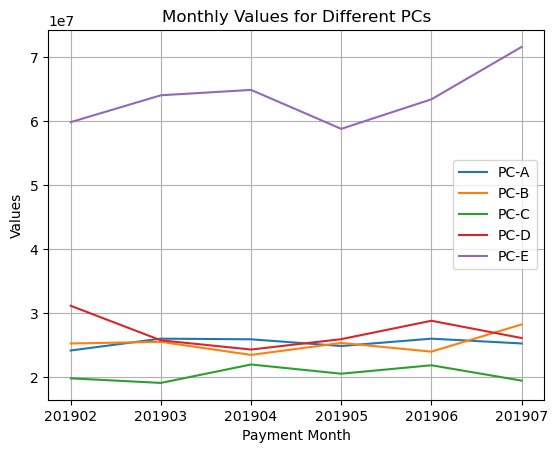

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline


# ループを用いて効率よく複数の折れ線グラフを描写
for column in graph_data.columns:
    plt.plot(graph_data.index, graph_data[column], label=column)
    print(column)

plt.xlabel('Payment Month')
plt.ylabel('Values')
plt.title('Monthly Values for Different PCs')
plt.legend()
plt.grid(True)


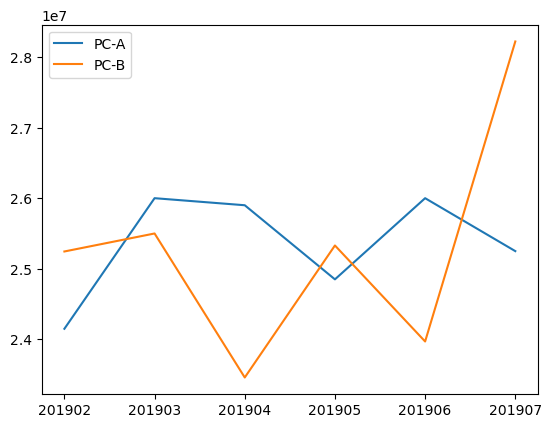

In [147]:
# 上記のコードをループなしで書くと以下のようになる。
plt.plot(list(graph_data.index), graph_data['PC-A'], label = 'PC-A')
plt.plot(list(graph_data.index), graph_data['PC-B'], label = 'PC-B')
# plt.plot(list(graph_data.index), graph_data['PC-C'], label = 'PC-C')
# plt.plot(list(graph_data.index), graph_data['PC-D'], label = 'PC-D')
# plt.plot(list(graph_data.index), graph_data['PC-E'], label = 'PC-E')
plt.legend()